## Problem - Customer Churn

We work for a fictitious telecommunications company 

One of the most important goals of the company is to increase customer loyalty. 

One strategy to achieve this goal is to identify customers who are likely to churn and approach them before they leave.

To do this, we'll look at historical customer data and see if we can develop a model that predicts churn based on various customer factors such as contract length, monthly payments, demographic information, etc.

This model would then help us to identify customers with a high risk of churn early enough so marketing could still address them e.g. with promotional packages.

## Import Packages

In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Get Data

In [48]:

df = pd.read_csv("https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")
df = df.query("Contract == 'Month-to-month'")

## Training-Testing Split

In [49]:
from sklearn.model_selection import train_test_split

# Define X and y
X = df.loc[:,['MonthlyCharges', 'tenure', 'SeniorCitizen']]
y = df['Churn']
y = y.map(dict(Yes=1, No=0))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify = y)

In [50]:
print(len(X_train), len(X_test))

3100 775


Inspect distribution of target in training and test set

In [51]:
print(pd.Series(y_train).value_counts(normalize = True))
print(pd.Series(y_test).value_counts(normalize = True))

Churn
0    0.572903
1    0.427097
Name: proportion, dtype: float64
Churn
0    0.572903
1    0.427097
Name: proportion, dtype: float64


### Model training with sklearn

In [52]:
# Define Model
from sklearn import linear_model
model = linear_model.LogisticRegression(fit_intercept = True)

# Train Model
model.fit(X_train, y_train)

# Show model
print(model.coef_)

# Model Performance (Accuracy)
print(model.score(X_train, y_train))

[[ 0.02558182 -0.0420351   0.63308752]]
0.675483870967742


In [53]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_train)
f1_score(y_pred, y_train)

0.5963081861958266

Evaluate on test set? Not so fast...

## Training with Cross-Validation 
### Implement CV (almost) from scratch with sklearn

In [54]:
from sklearn import model_selection
# Set parameter k
k = 5

# Concat X_train and y_train
kfold_df = X_train.copy()
kfold_df['target'] = y_train

# Shuffle the rows of the data frame
kfold_df = kfold_df.sample(frac=1, replace=False, random_state=123).reset_index(drop = True)
kfold_df['kfold'] = ""

# Initiate KFold class from scikit-learn
kf = model_selection.KFold(n_splits=k)

# Populate the kfold column
for fold, (train, validation) in enumerate(kf.split(X=kfold_df)):
 kfold_df.loc[validation, 'kfold'] = fold

# Inspect training data frame
kfold_df

,MonthlyCharges,tenure,SeniorCitizen,target,kfold
0,30.35,23,0,0,0
1,74.45,1,1,1,0
2,75.60,23,0,1,0
3,79.10,3,0,1,0
4,70.05,9,0,0,0
...,...,...,...,...,...
3095,19.65,1,0,1,4
3096,73.75,4,0,1,4
3097,64.10,40,0,0,4
3098,94.20,8,0,1,4


Cross validation training loop

In [55]:
# Train Model with Cross-Validation
mean_f1 = []

model = linear_model.LogisticRegression(fit_intercept = True)

for fold in range(0,k):

  # Training data is all but the provided fold
  fold_df = kfold_df[kfold_df['kfold'] != fold].reset_index(drop = True)

  # Validation fold is the fold provided
  valid_df = kfold_df[kfold_df['kfold'] == fold].reset_index(drop = True)

  # Assign feature & target columns
  X_train_cv = fold_df.drop("target", axis = 1)
  y_train_cv = fold_df['target']

  # Same for validation set
  X_valid_cv = valid_df.drop("target", axis = 1)
  y_valid_cv = valid_df['target']

  # Fit the model on training data
  model.fit(X_train_cv, y_train_cv)

  # Get predictions for validation samples
  predictions = model.predict(X_valid_cv)

  # Evaluate model
  f1 = f1_score(y_valid_cv, predictions)
  print(f"Fold = {fold}, F1 = {f1}")

  mean_f1.append(f1)

print(f"Average model F1-Score is {np.mean(mean_f1)}")

Fold = 0, F1 = 0.5756302521008403
Fold = 1, F1 = 0.588957055214724
Fold = 2, F1 = 0.58
Fold = 3, F1 = 0.6457925636007827
Fold = 4, F1 = 0.5692007797270955
Average model F1-Score is 0.5919161301286884


Great - we have validated our model accuracy using cross validation! Let's try different models / hyperparameters.

## Grid Search with CV

Hyperparameter tuning

In [56]:
from sklearn.model_selection import GridSearchCV

model = linear_model.LogisticRegression(fit_intercept = True, max_iter = 1000)

# Define grid
parameters = {'class_weight': [None, 'balanced'], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_search = GridSearchCV(model, parameters, cv = k, scoring = "f1")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'class_weight': [None, 'balanced'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [57]:
pd.DataFrame((grid_search.cv_results_)).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.095131,0.003779,0.003206,2.500654e-04,balanced,saga,"{'class_weight': 'balanced', 'solver': 'saga'}",0.596187,0.612389,0.605634,0.636364,0.636678,0.617450,0.016400,1
8,0.060822,0.008081,0.003200,3.990572e-04,balanced,sag,"{'class_weight': 'balanced', 'solver': 'sag'}",0.596187,0.612389,0.604240,0.637478,0.636678,0.617395,0.016870,2
7,0.005402,0.000800,0.003624,5.082412e-04,balanced,liblinear,"{'class_weight': 'balanced', 'solver': 'liblin...",0.596187,0.612389,0.604240,0.636364,0.636678,0.617172,0.016609,3
5,0.013408,0.001585,0.004100,6.045334e-04,balanced,newton-cg,"{'class_weight': 'balanced', 'solver': 'newton...",0.596187,0.609929,0.602837,0.637478,0.635417,0.616370,0.016972,4
6,0.011808,0.000709,0.003830,4.184156e-04,balanced,lbfgs,"{'class_weight': 'balanced', 'solver': 'lbfgs'}",0.596187,0.609929,0.602837,0.637478,0.635417,0.616370,0.016972,4
0,0.013514,0.001687,0.003822,7.806644e-04,None,newton-cg,"{'class_weight': None, 'solver': 'newton-cg'}",0.572565,0.572000,0.592000,0.631365,0.605210,0.594628,0.022214,6
1,0.011127,0.000698,0.003800,3.999955e-04,None,lbfgs,"{'class_weight': None, 'solver': 'lbfgs'}",0.572565,0.572000,0.592000,0.631365,0.605210,0.594628,0.022214,6
2,0.006206,0.001716,0.004312,5.648758e-04,None,liblinear,"{'class_weight': None, 'solver': 'liblinear'}",0.572565,0.570281,0.592000,0.631365,0.600000,0.593242,0.022160,8
3,0.057059,0.008987,0.003295,4.333612e-04,None,sag,"{'class_weight': None, 'solver': 'sag'}",0.572565,0.570281,0.592000,0.631365,0.600000,0.593242,0.022160,8
4,0.095928,0.005703,0.002998,7.231594e-07,None,saga,"{'class_weight': None, 'solver': 'saga'}",0.572565,0.570281,0.592000,0.627291,0.600000,0.592427,0.020775,10


In [58]:
grid_search.best_estimator_

LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')

In [59]:
# Train model on full training set with best estimator
best_model = grid_search.best_estimator_

# Fit the model on training data
best_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')

Inspect Confusion Matrix

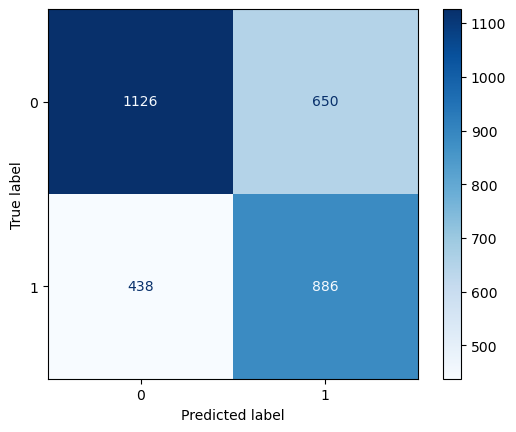

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score, roc_curve, roc_auc_score
y_pred = best_model.predict(X_train)

cm = confusion_matrix(y_train, y_pred, labels = best_model.classes_)
conf  = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model .classes_)
conf.plot(cmap = "Blues");

* **Top left**: Actual negative, negative positive = True Negatives
* **Top right**: Actual negative, predicted positive = False Positives
* **Bottom left**: Actual positive, predicted negative = False Negatives
* **Bottom right**: Actual positive, predicted positive = True Positives

### Evaluation

In [61]:
# Calculate F1-Score for test set
y_pred = best_model.predict(X_test)
f1_score(y_test, y_pred)

0.6289655172413793

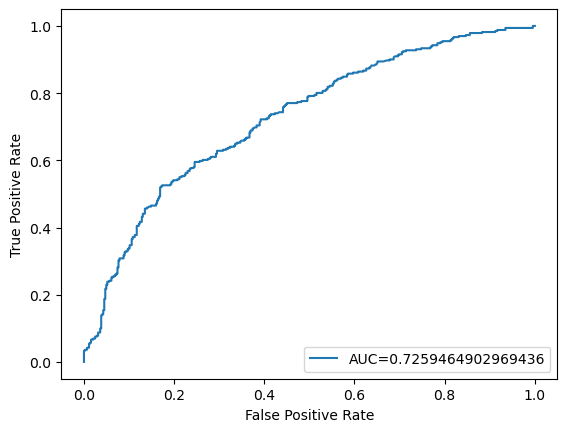

In [62]:
#define metrics
y_pred_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()